By: Ryan Howarth - 251109839
Date: 2022-12-08

In [128]:
#Imports
import numpy as np
import pandas as pd
#!pip install torchvision
import torch as to
import torchvision as tv


In [129]:
#To increase the speed of the training
device = to.device('cuda:0' if to.cuda.is_available() else 'cpu')

#Setting up datasets
transform = tv.transforms.Compose([tv.transforms.Resize(224), tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainData = tv.datasets.CIFAR10('./', train = True, download = True, transform = transform)
testData = tv.datasets.CIFAR10('./', train = False, download = True, transform = transform)
trainData, valData = to.utils.data.random_split(trainData, [40000, 10000])
print(f'Shape (Train and Val): {len(trainData)} {len(valData)}')


#Setting up dataloaders
trainLoad = to.utils.data.DataLoader(trainData, batch_size = 4, shuffle = True, num_workers = 2)
valLoad = to.utils.data.DataLoader(valData, batch_size = 4, shuffle = True, num_workers = 2)
testLoad = to.utils.data.DataLoader(testData, batch_size = 4, shuffle = False, num_workers = 2)
print(f'Train Data: {trainData}\nValidation Data: {valData}\nTest Data: {testData}')

alexnet = tv.models.alexnet(pretrained = True)
alexnet.eval()
alexnet.to(device)

Files already downloaded and verified
Files already downloaded and verified
Shape (Train and Val): 40000 10000
Train Data: <torch.utils.data.dataset.Subset object at 0x7ff3f6be2580>
Validation Data: <torch.utils.data.dataset.Subset object at 0x7ff3f60e9fd0>
Test Data: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [130]:
#Question b
#Training the model on the train data and validation data
#Optimizer
optim = to.optim.SGD(alexnet.parameters(), lr = 0.001, momentum = 0.9)
#Loss
criterion = to.nn.CrossEntropyLoss()

runLoss = 0
for i, data in enumerate(trainLoad, 0):
    input, labels = data[0].to(device), data[1].to(device)

    optim.zero_grad()

    output = alexnet(input)
    loss = criterion(output, labels)
    loss.backward()
    optim.step()
        
    runLoss += loss.item()
    if i % 2000 == 1999:
        print(f'[{1}, {i + 1:5d}] loss: {runLoss / 2000:.3f}')
        runLoss = 0.0
  
correct = 0
total = 0

alexnet.eval()
with to.no_grad():
  for data in valLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnet(image)

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()

print(f'The accuracy of the model after training/validation is: {(correct / total) * 100} %')

[1,  2000] loss: 1.595
[1,  4000] loss: 0.927
[1,  6000] loss: 0.749
[1,  8000] loss: 0.679
[1, 10000] loss: 0.623
The accuracy of the model after training/validation is: 81.53 %


In [131]:
#Testing the model on the test data
correct = 0
total = 0
indice = []
testLabels = []

alexnet.eval()
with to.no_grad():
  for data in testLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnet(image)

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()
    indice.append(pred[0].cpu().numpy())
    testLabels.append(label[0].cpu().numpy())

print(f'The accuracy of the model after testing is: {(correct / total) * 100} %')

The accuracy of the model after testing is: 81.52000000000001 %


In [132]:
#Getting imageNet classes
imageNetClasses = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header = None)
imageNetClasses.head()

,0
0,tench
1,goldfish
2,great white shark
3,tiger shark
4,hammerhead


301               ladybug
240           Appenzeller
245        French bulldog
263              Pembroke
214         Gordon setter
237    miniature pinscher
292                 tiger
225              malinois
240           Appenzeller
243          bull mastiff
Name: 0, dtype: object


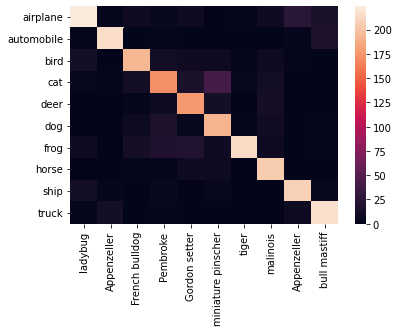

In [133]:
#Constructing the confusion matrix
from sklearn.metrics import confusion_matrix
#from Collections import Counter
import seaborn as sns

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#Getting the most frequent imagenet classes
frequentIndice = np.bincount(indice, minlength = 10)
imageNetFreq = imageNetClasses[0][frequentIndice]
print(imageNetFreq)

#Constructing confusion matrix
confusionMatrix = confusion_matrix(indice, testLabels)
sns.heatmap(confusionMatrix, xticklabels = imageNetFreq, yticklabels = classes)

In [134]:
#Question c
#Getting the fc6 layer model
alexnetFC6 = tv.models.alexnet(pretrained = True)
alexnetFC6.classifier = alexnet.classifier[:-5]
alexnetFC6.eval()
alexnetFC6.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [145]:
#Training the model with training data using fc6 layer
#Optimizer
optim = to.optim.SGD(alexnetFC6.parameters(), lr = 0.001, momentum = 0.9)
#Loss
criterion = to.nn.CrossEntropyLoss()

trainOutput = []
trainLabels = []
runLoss = 0
for i, data in enumerate(trainLoad, 0):
    input, labels = data[0].to(device), data[1].to(device)

    optim.zero_grad()

    output = alexnetFC6(input)
    trainOutput.append(output[0].detach().cpu().numpy())
    trainLabels.append(labels[0].detach().cpu().numpy())
    loss = criterion(output, labels)
    loss.backward()
    optim.step()
        
    runLoss += loss.item()
    if i % 2000 == 1999:
        print(f'[{1}, {i + 1:5d}] loss: {runLoss / 2000:.3f}')
        runLoss = 0.0

[1,  2000] loss: 0.600
[1,  4000] loss: 0.605
[1,  6000] loss: 0.615
[1,  8000] loss: 0.626
[1, 10000] loss: 0.574


In [146]:
#Validation data training
correct = 0
total = 0
valOutput = []
valLabels = []

alexnetFC6.eval()
with to.no_grad():
  for data in valLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnetFC6(image)
    valOutput.append(output[0].cpu().numpy())
    valLabels.append(labels[0].cpu().numpy())

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()

print(f'The accuracy of the model after training/validation is: {(correct / total) * 100} %')

The accuracy of the model after training/validation is: 78.01 %


In [137]:
#Testing the model with the test data using fc6 layer
correct = 0
total = 0
testOutput = []
testLabels = []

alexnetFC6.eval()
with to.no_grad():
  for data in testLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnetFC6(image)
    testOutput.append(output[0].cpu().numpy())
    testLabels.append(labels[0].cpu().numpy())

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()

print(f'The accuracy of the model after testing is: {(correct / total) * 100} %')

The accuracy of the model after testing is: 75.82 %


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score (With all the train data): 0.7896
Accuracy Score (With all the test data): 0.424


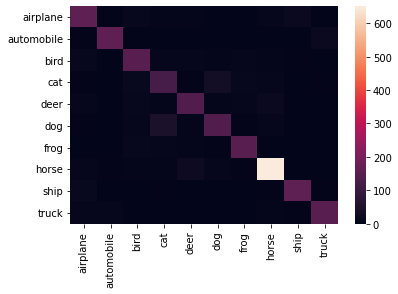

In [147]:
#Training a logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Creating the Logistic Regression
xtrain, xtest, ytrain, ytest = train_test_split((trainOutput + valOutput), (trainLabels + valLabels), test_size = 0.2, random_state = 0)
logReg6 = LogisticRegression().fit(xtrain, ytrain)
fc6Pred = logReg6.predict(xtest)

#Printing Scores
conFC6 = confusion_matrix(ytest, fc6Pred)
sns.heatmap(conFC6, xticklabels = classes, yticklabels = classes)
print(f'Accuracy Score (With all the train data): {logReg6.score(xtest, ytest)}')
print(f'Accuracy Score (With all the test data): {logReg6.score(testOutput, testLabels)}')

In [148]:
#Question d
#Getting the fc7 layer model
alexnetFC7 = tv.models.alexnet(pretrained = True)
alexnetFC7.classifier = alexnet.classifier[:-1]
alexnetFC7.eval()
alexnetFC7.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [149]:
#Training the model with training data using fc7 layer
#Optimizer
optim = to.optim.SGD(alexnetFC7.parameters(), lr = 0.001, momentum = 0.9)
#Loss
criterion = to.nn.CrossEntropyLoss()

trainOutput = []
trainLabels = []
runLoss = 0
for i, data in enumerate(trainLoad, 0):
    input, labels = data[0].to(device), data[1].to(device)

    optim.zero_grad()

    output = alexnetFC7(input)
    trainOutput.append(output[0].detach().cpu().numpy())
    trainLabels.append(labels[0].detach().cpu().numpy())
    loss = criterion(output, labels)
    loss.backward()
    optim.step()
        
    runLoss += loss.item()
    if i % 2000 == 1999:
        print(f'[{1}, {i + 1:5d}] loss: {runLoss / 2000:.3f}')
        runLoss = 0.0
  
#Validation data training
correct = 0
total = 0
valOutput = []
valLabels = []

alexnetFC6.eval()
with to.no_grad():
  for data in valLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnetFC7(image)
    valOutput.append(output[0].cpu().numpy())
    valLabels.append(labels[0].cpu().numpy())

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()

print(f'The accuracy of the model after training/validation is: {(correct / total) * 100} %')

[1,  2000] loss: 2.171
[1,  4000] loss: 1.645
[1,  6000] loss: 1.544
[1,  8000] loss: 1.467
[1, 10000] loss: 1.451
The accuracy of the model after training/validation is: 71.50999999999999 %


In [151]:
#Testing the model with the test data using fc7 layer
correct = 0
total = 0
testOutput = []
testLabels = []

alexnetFC6.eval()
with to.no_grad():
  for data in testLoad:
    image, label = data[0].to(device), data[1].to(device)

    output = alexnetFC7(image)
    testOutput.append(output[0].cpu().numpy())
    testLabels.append(labels[0].cpu().numpy())

    _, pred = to.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()

print(f'The accuracy of the model after testing is: {(correct / total) * 100} %')

The accuracy of the model after testing is: 71.72 %


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score (With all the train data): 0.7408
Accuracy Score (With all the test data): 0.0416


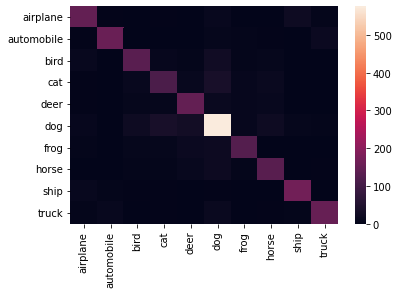

In [152]:
#Creating the Logistic Regression
xtrain, xtest, ytrain, ytest = train_test_split((trainOutput + valOutput), (trainLabels + valLabels), test_size = 0.2, random_state = 0)
logReg7 = LogisticRegression().fit(xtrain, ytrain)
fc7Pred = logReg7.predict(xtest)

#Printing Scores
conFC7 = confusion_matrix(ytest, fc7Pred)
sns.heatmap(conFC7, xticklabels = classes, yticklabels = classes)
print(f'Accuracy Score (With all the train data): {logReg7.score(xtest, ytest)}')
print(f'Accuracy Score (With all the test data): {logReg6.score(testOutput, testLabels)}')

Compared to the model using the fc6 layer, the fc7 layer has a lower score overall in the training data with 0.7408 compared to to fc6's score of 0.7896.  On top of this, the test data score is significantly lower than the fc6's test data score.  This is most likely due to the fact that the features extracted from the fc6 layer are more compatible with the logistic regression and therefore produce an overall higher accuracy than the features extracted from the fc7 layer.  Furthering this point, we can see from the training and testing of the model that there is much more significant loss in the fc7 layer and that the accuracy of the model is slightly lower in general which most likely has an affect on the outcome of the logistic regression